In [1]:
import numpy as np
from glob import glob
from tqdm import tqdm
import torch
import keras as k
import torchvision.models as models
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense, Activation
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from keras.optimizers import Adam, Adamax
import gc
import matplotlib.pyplot as plt

gc.collect()

torch.cuda.empty_cache()

In [2]:
resnet = models.resnet18(pretrained=True)
print(resnet)
print(resnet.fc.in_features) 
print(resnet.fc.out_features)
# check if CUDA is available
use_cuda = torch.cuda.is_available()


Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [3]:
transform = transforms.Compose([transforms.RandomResizedCrop(224), 
                                      transforms.ToTensor(),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.RandomRotation(20),
                                   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
dataset = datasets.ImageFolder('../input/satellite-image-classification/data', transform=transform)
train_data, val_data,test_data = torch.utils.data.random_split(dataset, [3950, 1120,561])
print('Num training images: ', len(train_data))
print('Num test images: ', len(val_data))
print('Num test images: ', len(test_data))


Num training images:  3950
Num test images:  1120
Num test images:  561


In [4]:
# define dataloader parameters
batch_size = 124
num_workers=0

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, 
                                          num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
                                          num_workers=num_workers, shuffle=True)
loaders = {
    'train': train_loader,
    'valid': valid_loader,
    'test': test_loader
}

In [5]:
n_inputs = resnet.fc.in_features
last_layer = nn.Linear(n_inputs, 4)
resnet.fc = last_layer
print(resnet.fc.out_features)

4


In [6]:
# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer (stochastic gradient descent) and learning rate = 0.001
optimizer = optim.SGD(resnet.fc.parameters(), lr=0.001)

In [7]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path, last_validation_loss=None):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    train_loss_ls = []
    valid_loss_ls = []
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        trainLoss = 0.0
        train_batch = 0
        validLoss = 0.0
        valid_batch = 0
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            
            # move to GPU
            if use_cuda:
                model = model.to('cuda')
                data, target = data.to('cuda'), target.to('cuda')
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            trainLoss += train_loss
            train_batch += 1
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            
            # move to GPU
            if use_cuda:
                model = model.to('cuda')
                data, target = data.to('cuda'), target.to('cuda')
            ## update the average validation loss
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
            validLoss += valid_loss
            valid_batch += 1
            

        
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        valid_loss_ls.append(validLoss/valid_batch)
        train_loss_ls.append(trainLoss/train_batch)
        ## TODO: save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), 'model.pt')
            valid_loss_min = valid_loss
    # return trained model
    plt.plot(train_loss_ls,'-o')
    plt.plot(valid_loss_ls,'-o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train','Valid'])
    plt.title('Train vs Valid Loss')
    plt.show()
    return model

Epoch: 1 	Training Loss: 1.272410 	Validation Loss: 1.182564
Validation loss decreased (inf --> 1.182564).  Saving model ...
Epoch: 2 	Training Loss: 1.091163 	Validation Loss: 0.998428
Validation loss decreased (1.182564 --> 0.998428).  Saving model ...
Epoch: 3 	Training Loss: 0.955617 	Validation Loss: 0.885640
Validation loss decreased (0.998428 --> 0.885640).  Saving model ...
Epoch: 4 	Training Loss: 0.856537 	Validation Loss: 0.811568
Validation loss decreased (0.885640 --> 0.811568).  Saving model ...
Epoch: 5 	Training Loss: 0.778807 	Validation Loss: 0.733429
Validation loss decreased (0.811568 --> 0.733429).  Saving model ...
Epoch: 6 	Training Loss: 0.715359 	Validation Loss: 0.676779
Validation loss decreased (0.733429 --> 0.676779).  Saving model ...
Epoch: 7 	Training Loss: 0.658138 	Validation Loss: 0.647583
Validation loss decreased (0.676779 --> 0.647583).  Saving model ...
Epoch: 8 	Training Loss: 0.621461 	Validation Loss: 0.593505
Validation loss decreased (0.64758

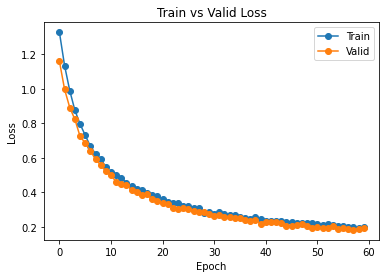

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [8]:
train(60, loaders, resnet, optimizer, 
                      criterion, use_cuda, 'saved_models/model.pt')

# load the model that got the best validation accuracy

In [9]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            model = model.to('cuda')
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# call test function    
test(loaders, resnet, criterion, use_cuda)

Test Loss: 0.187907


Test Accuracy: 96% (541/561)
